In [1]:
from pyebm import debm
from pyebm import load_dataset as ld

D=ld.load_dataset('EBMData')
ModelOutput, SubjTrain, SubjTest = debm.fit(D)
print([ModelOutput.BiomarkerList[x] for x in ModelOutput.MeanCentralOrdering])

## The same syntax applies to ebm.fit as well. 
# from pyebm import ebm
# ModelOutput, SubjTrain, SubjTest = ebm.fit(D)

['ABETA', 'MMSE', 'PTAU', 'ADAS13', 'Hippocampus', 'TAU', 'WholeBrain']


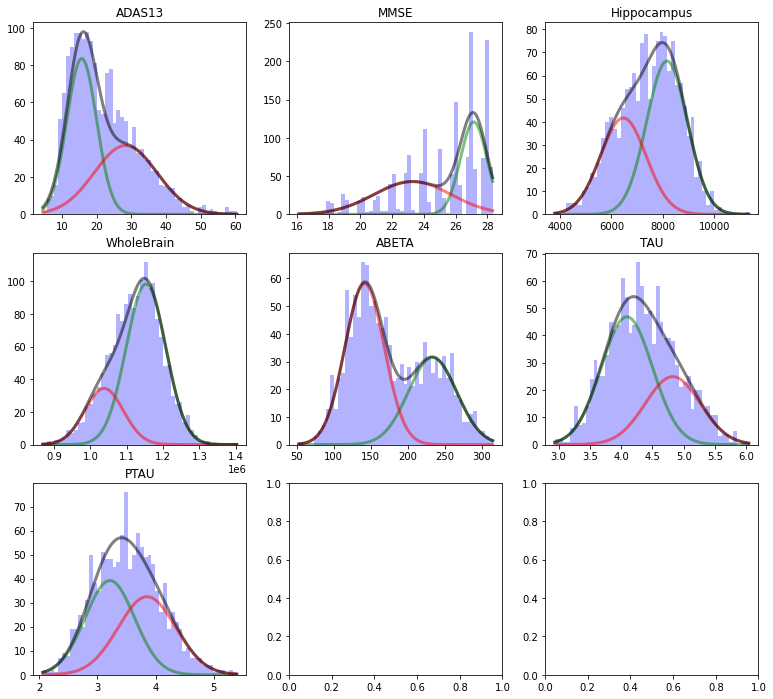

In [2]:
## Example with Visual Biomarker Distributions as output
from pyebm import load_dataset as ld
from pyebm import debm
from collections import namedtuple

MO = namedtuple('MethodOptions', 'MixtureModel Bootstrap')
MO.Bootstrap = 0;
MO.MixtureModel = 'GMMvv2';
VO = namedtuple('VerboseOptions', 'Distributions')
VO.Distributions = 1; # Displays distributions fit after Gaussian mixture modeling
D=ld.load_dataset('EBMData')
ModelOutput, SubjTrain, SubjTest = debm.fit(D, MethodOptions=MO, VerboseOptions=VO)


[0][1][2][3][4]

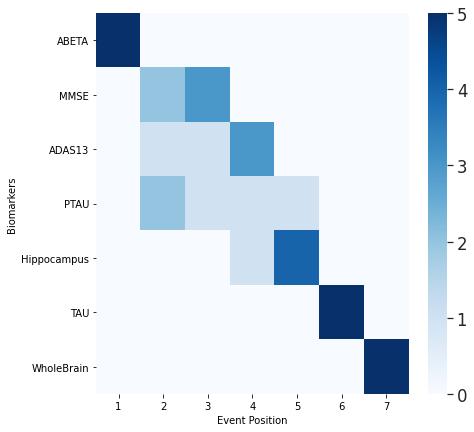

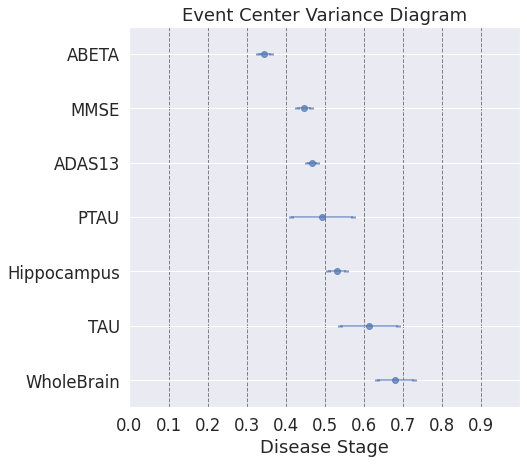

In [3]:
## Example with bootstrapping and visual output
from pyebm import load_dataset as ld
from pyebm import debm
from collections import namedtuple

MO = namedtuple('MethodOptions', 'MixtureModel Bootstrap')
MO.Bootstrap = 5; # Number of bootstrap iterations
MO.MixtureModel = 'GMMvv2';
VO = namedtuple('VerboseOptions', 'Ordering PlotOrder Distributions')
VO.Ordering = 1; # Displays the estimated ordering and the uncertainty in the estimated ordering
VO.PlotOrder = 1; # 1 - shows the output in the order of the events estimated. 
## 0 - shows the output in the order present in the dataframe
VO.Distributions = 0;
D=ld.load_dataset('EBMData')
ModelOutput, SubjTrain, SubjTest = debm.fit(D, MethodOptions=MO, VerboseOptions=VO)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Estimated patient stages of subjects in training set


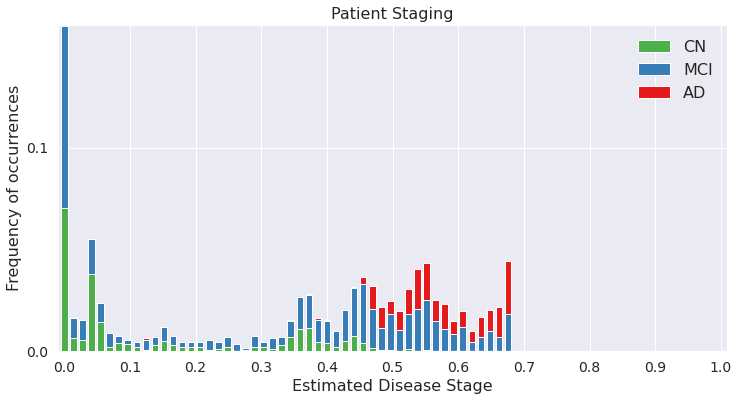

In [4]:
## Example with Patient Staging and visual output. Also, a pandas dataframe can be sent as an input instead of CSV
from pyebm import load_dataset as ld
from pyebm import debm
from collections import namedtuple

MO = namedtuple('MethodOptions', 'MixtureModel Bootstrap PatientStaging')
MO.Bootstrap = 0;
MO.MixtureModel = 'GMMvv2';
MO.PatientStaging = ['exp', 'p'] # Patient staging as introduced in the DEBM paper by Venkatraghavan et al. NeuroImage 2019.
## Alternately PatientStaging can be set to ['ml', 'l'] for Patient staging as introduced in the classifical EBM by Fonteijn et al. NeuroImage 2012.
VO = namedtuple('VerboseOptions', 'Distributions PatientStaging')
VO.PatientStaging = 1; # Displays the patient staging output
VO.Distributions = 0;

D=ld.load_dataset('EBMData')
ModelOutput, SubjTrain, SubjTest = debm.fit(D, MethodOptions=MO, VerboseOptions=VO)

In [5]:
## Comparing AUCs of Patient Staging using Cross-Validation with Training and Testset
## Comparison will be done between DEBM / EBM

from collections import namedtuple
from pyebm import load_dataset as ld
from pyebm import debm
from pyebm import ebm
from sklearn.model_selection import KFold as KF
from sklearn import metrics
import numpy as np
import pandas as pd

MO1 = namedtuple('MethodOptions', 'MixtureModel Bootstrap PatientStaging')
MO1.Bootstrap = 0;
MO1.MixtureModel = 'GMMvv2';
MO1.PatientStaging = ['exp', 'p']

MO2 = namedtuple('MethodOptions', 'MixtureModel Bootstrap PatientStaging')
MO2.Bootstrap = 0;
MO2.MixtureModel = 'GMMvv2';
MO2.PatientStaging = ['ml', 'l']

VO = namedtuple('VerboseOptions', 'Distributions PatientStaging')
VO.PatientStaging = 0;
VO.Distributions = 0;

D=ld.load_dataset('EBMData')
Y = D['Diagnosis'].copy();
Y[Y == 'CN'] = 0;
Y[Y == 'AD'] = 2;
Y[Y == 'MCI'] = 1;

skf = KF(n_splits=10, shuffle=True, random_state=42)
print("Comparing the AUCs of CN / AD Classification:")
print("Cross-Validation Iteration:")
auc1 = [];
auc2 = [];

count = -1
for train_index, test_index in skf.split(D, pd.to_numeric(Y.values)):
    count = count + 1;
    print([count],end="")
    DTrain, DTest = D.iloc[train_index], D.iloc[test_index]
    ModelOutput1, SubjTrain1, SubjTest1 = debm.fit(DTrain, MethodOptions=MO1, VerboseOptions=VO, DataTest=DTest)
    ModelOutput2, SubjTrain2, SubjTest2 = ebm.fit(DTrain, MethodOptions=MO2, VerboseOptions=VO, DataTest=DTest)
    Y = DTest['Diagnosis']
    idx = Y != 'MCI';
    Y = Y[idx];
    Y[Y == 'CN'] = 0;
    Y[Y == 'AD'] = 1;

    S = SubjTest1[0]['Stages'];
    S = S.values[idx];
    auc1.append(metrics.roc_auc_score(pd.to_numeric(Y.values), S))
    S = SubjTest2[0]['Stages'];
    S = S.values[idx];
    auc2.append(metrics.roc_auc_score(pd.to_numeric(Y.values), S))

print("\nMean AUC using DEBM with Patient Staging Option:", MO1.PatientStaging, '--->', np.mean(auc1))
print("Mean AUC using EBM with Patient Staging Option:", MO2.PatientStaging, '--->', np.mean(auc2))

Comparing the AUCs of CN / AD Classification:
Cross-Validation Iteration:
[0]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[1]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[2][3]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[4]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[5]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[6]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[7]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp


[8][9]

/mnt/data/VirtualEnvironments/pyebm-test/pyebm-test/lib/python3.6/site-packages/pyebm-2.0.1-py3.6.egg/pyebm/central_ordering/data_likelihood.py:59: RuntimeWarning: overflow encountered in exp



Mean AUC using DEBM with Patient Staging Option: ['exp', 'p'] ---> 0.9858100157016112
Mean AUC using EBM with Patient Staging Option: ['ml', 'l'] ---> 0.9665712514955835
